# GRAPE on a Kerr oscillator

In this example we will try to implement DRAG-like pulses on a Kerr oscillator, penalizing population going to leakage states. We will additionally use a slightly more complicated control scheme than in the qubit example, where we fit a spline to the optimized control points as opposed to using piece-wise constant controls.

This technique has the benefit of ensuring smooth controls if the control points are spread far enough apart in time, which is not guaranteed in the case of piece-wise constant controls. It is important to emphasize here that the control points are in no way related to the points chosen by the numerical integrator for solving the differential equation! This is a significant difference from typical QOC/GRAPE implementations that perform numerical integration of the Schrödinger equation by calculating step propagators with sufficiently small time steps.

This example is available as a Jupyter notebook [here](https://github.com/dkweiss31/qontrol/blob/main/docs/examples/Kerr_oscillator.ipynb).

In [1]:
import diffrax as dx
import dynamiqs as dq
import jax.numpy as jnp
import jax.tree_util as jtu
import matplotlib.pyplot as plt
import numpy as np
import optax
from jax import Array

import qontrol as ql

In [2]:
time = 20.0
control_dt = 2.0
ramp_nts = 4
ntimes = int(time // control_dt) + 1
tsave = jnp.linspace(0, time, ntimes)
optimizer = optax.adam(learning_rate=0.001, b1=0.999, b2=0.999)
options = ql.OptimizerOptions(
    verbose=False,
    save_states=True,
    progress_meter=None,
    epochs=4000,
    plot=True,
    plot_period=20,
)

We define our Kerr oscillator to have a 100 MHz Kerr. We optimize the drive envelopes on the I and Q quadratures.

In [3]:
dim = 5
Kerr = -2.0 * jnp.pi * 0.100
a = dq.destroy(dim)
H0 = -0.5 * Kerr * dq.dag(a) @ dq.dag(a) @ a @ a
H1s = [a + dq.dag(a), 1j * (a - dq.dag(a))]
H1_labels = ['I', 'Q']

Here we attempt to perform an `X` gate, and penalize population leaking to the higher-lying states

In [4]:
initial_states = [dq.basis(dim, 0), dq.basis(dim, 1)]
final_states = [dq.basis(dim, 1), dq.basis(dim, 0)]
_forbidden_states = [dq.basis(dim, idx) for idx in range(2, dim)]
forbidden_states_list = len(initial_states) * [_forbidden_states]

We initialize the guess for the controls and moreover define an envelope of cosine ramps with a flat top to ensure that the control turns on slowly.

In [5]:
init_drive_params = {'dp': -0.001 * jnp.ones((len(H1s), ntimes))}

cos_ramp = (1 - jnp.cos(jnp.linspace(0.0, jnp.pi, ramp_nts))) / 2
envelope = jnp.concatenate(
    (cos_ramp, jnp.ones(ntimes - 2 * ramp_nts), jnp.flip(cos_ramp))
)


def _drive_spline(
    drive_params: Array, envelope: Array, ts: Array
) -> dx.CubicInterpolation:
    drive_w_envelope = jnp.einsum('t,...t->t...', envelope, drive_params)
    drive_coeffs = dx.backward_hermite_coefficients(ts, drive_w_envelope)
    return dx.CubicInterpolation(ts, drive_coeffs)


def H_func(drive_params_dict: dict) -> dq.TimeArray:
    drive_params = drive_params_dict['dp']
    H = H0
    for H1, drive_param in zip(H1s, drive_params):
        drive_spline = _drive_spline(drive_param, envelope, tsave)
        H += dq.modulated(drive_spline.evaluate, H1)
    return H


exp_ops = [dq.basis(dim, idx) @ dq.dag(dq.basis(dim, idx)) for idx in range(dim)]

se_Kerr_model = ql.sesolve_model(H_func, initial_states, tsave, exp_ops=exp_ops)

In [6]:
costs = ql.coherent_infidelity(target_states=final_states, target_cost=0.005)
costs += 40.0 * ql.forbidden_states(
    forbidden_states_list=forbidden_states_list, target_cost=0.5
)

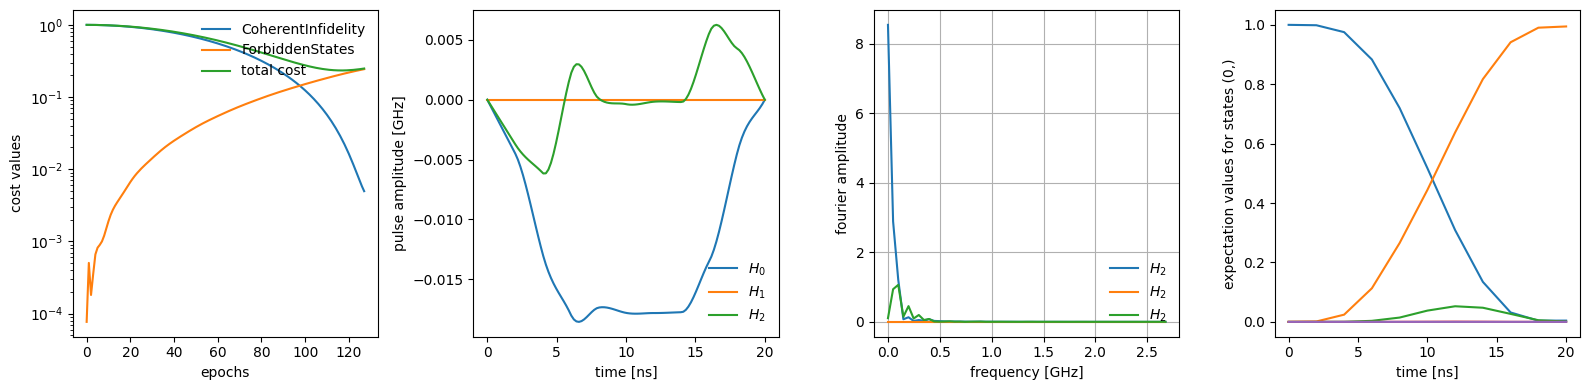

target cost reached for all cost functions;
optimization terminated after 127 epochs; 
average epoch time (excluding jit) of 0.00101 s; 
max epoch time of 0.002 s; 
min epoch time of 0.001 s


In [7]:
opt_params = ql.optimize(
    init_drive_params, costs, model=se_Kerr_model, optimizer=optimizer, options=options
)

Try playing with the `cost_multiplier` of the forbidden states cost function to see how it modifies the pulse! Specifically, try setting it to 0 so that the optimizer is happy to populate the 2nd excited state without penalty.

## Time-optimal control

We can modify the above example to perform time-optimal control, allowing the optimizer to make the pulse longer or shorter. Notice the additional parameter in `init_drive_params` that controls the pulse time. We now provide an additional update function that updates `tsave` during the optimization.

In [8]:
init_drive_params_topt = {'dp': -0.001 * jnp.ones((len(H1s), ntimes)), 't': tsave[-1]}


def H_func_topt(t: float, drive_params_dict: dict) -> dq.TimeArray:
    drive_params = drive_params_dict['dp']
    new_tsave = jnp.linspace(0.0, drive_params_dict['t'], len(tsave))
    drive_spline = _drive_spline(drive_params, envelope, new_tsave)
    drive_amps = drive_spline.evaluate(t)
    drive_Hs = jnp.einsum('d,dij->ij', drive_amps, H1s)
    return H0 + drive_Hs


def update_H_topt(drive_params_dict: dict) -> dq.TimeArray:
    new_H = jtu.Partial(H_func_topt, drive_params_dict=drive_params_dict)
    return dq.timecallable(new_H)


def update_tsave_topt(drive_params_dict: dict) -> Array:
    return jnp.linspace(0.0, drive_params_dict['t'], len(tsave))


se_t_opt_Kerr_model = ql.sesolve_model(
    update_H_topt, initial_states, update_tsave_topt, exp_ops=exp_ops
)

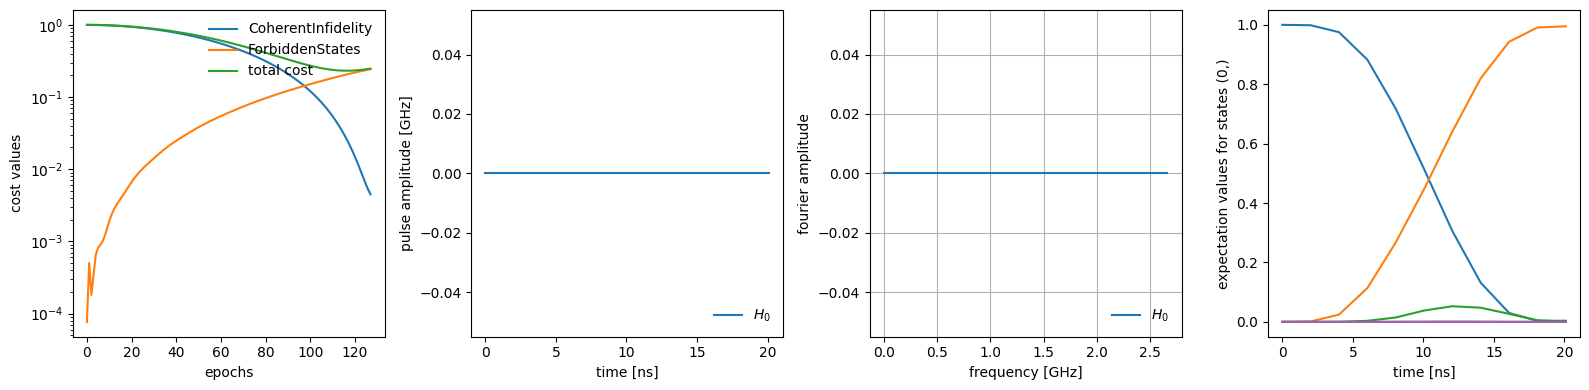

target cost reached for all cost functions;
optimization terminated after 127 epochs; 
average epoch time (excluding jit) of 0.00206 s; 
max epoch time of 0.003 s; 
min epoch time of 0.002 s


In [9]:
opt_params_topt = ql.optimize(
    init_drive_params_topt,
    costs,
    se_t_opt_Kerr_model,
    optimizer=optimizer,
    options=options,
)

The pulse and fft don't get plotted in this case because the Hamiltonian is of type `dq.timecallable`, which does not technically have a `prefactor` attribute. We plot the pulse below.

In [10]:
# helper plotting function for the multiple variations
def plot_pulse(_opt_params: dict, _model: ql.Model) -> None:
    result, _H = _model(_opt_params)
    _tsave = _model.tsave_function(_opt_params)

    drive_spline = _drive_spline(_opt_params['dp'], envelope, _tsave)
    finer_times = jnp.linspace(0.0, _tsave[-1], 201)
    drive_amps = jnp.asarray([drive_spline.evaluate(t) for t in finer_times]).swapaxes(
        0, 1
    )
    fig, ax = plt.subplots(figsize=(5, 4))
    fig.patch.set_alpha(0.1)
    ax.set_facecolor('none')
    for drive_idx in range(len(H1s)):
        ax.plot(
            finer_times,
            drive_amps[drive_idx] / (2.0 * np.pi),
            label=H1_labels[drive_idx],
        )
    ax.set_xlabel('time [ns]')
    ax.set_ylabel('pulse amplitude [GHz]')
    ax.legend(framealpha=0.0)
    plt.tight_layout()
    plt.show()

|██████████| 100.0% ◆ elapsed 3.67ms ◆ remaining 0.00ms


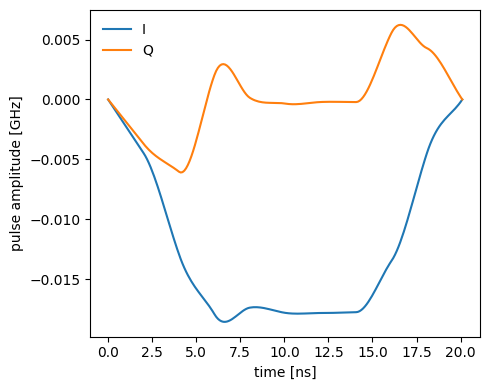

In [11]:
plot_pulse(opt_params_topt, se_t_opt_Kerr_model)

We can see that the optimizer chooses to make the pulse slightly longer to reduce the amount of leakage.

## Master-equation optimization

We can also instead perform the optimization directly on the master equation. This example is interesting because photon loss encourages the optimizer to make the pulse shorter, which competes with leakage effects. Continuing the above example, we need now to initialize an `mesolve_model`, which calls `dq.mesolve`, and to correctly specify the initial and target states as density matrices.

In [12]:
jump_ops = [0.03 * a]
me_initial_states = dq.todm(initial_states)
me_final_states = dq.todm(final_states)
me_forbidden_states_list = len(initial_states) * [dq.todm(_forbidden_states)]
me_costs = ql.coherent_infidelity(target_states=me_final_states)
me_costs += 60.0 * ql.forbidden_states(forbidden_states_list=me_forbidden_states_list)

me_Kerr_model = ql.mesolve_model(
    update_H_topt, jump_ops, me_initial_states, update_tsave_topt, exp_ops=exp_ops
)

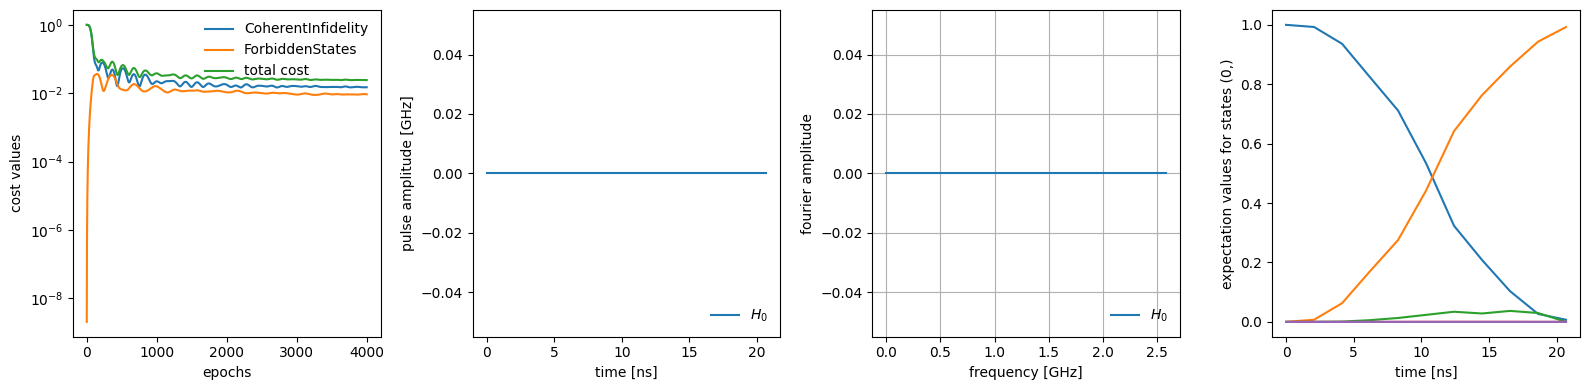

reached maximum number of allowed epochs;
optimization terminated after 3999 epochs; 
average epoch time (excluding jit) of 0.00489 s; 
max epoch time of 0.012 s; 
min epoch time of 0.003 s


In [13]:
opt_params_me = ql.optimize(
    init_drive_params_topt,
    me_costs,
    me_Kerr_model,
    optimizer=optimizer,
    options=options,
)

|██████████| 100.0% ◆ elapsed 3.12ms ◆ remaining 0.00ms


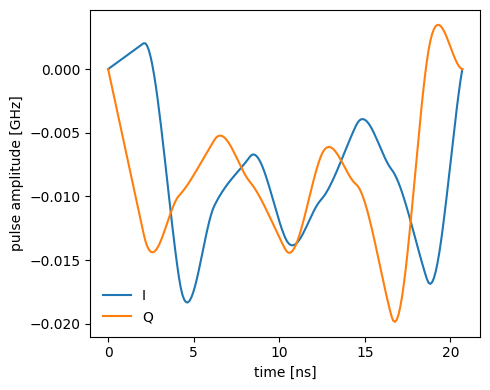

In [14]:
plot_pulse(opt_params_me, me_Kerr_model)